# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, and transfering of HBR models. 

### Imports

In [1]:
import pcntoolkit as ptk
import pandas as pd
import numpy as np
import pprint
import arviz as az
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param
import seaborn as sns

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

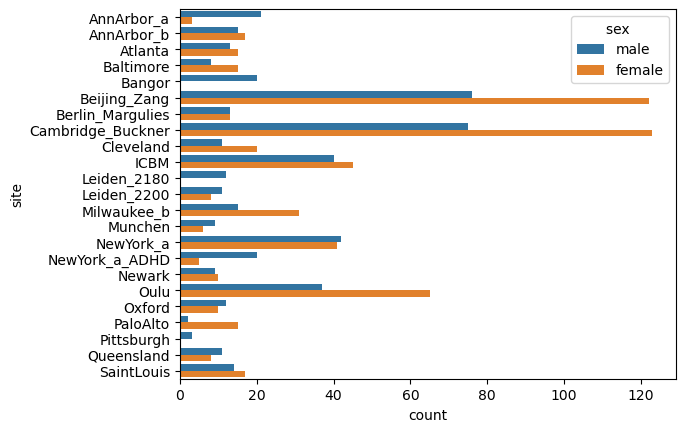

In [3]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

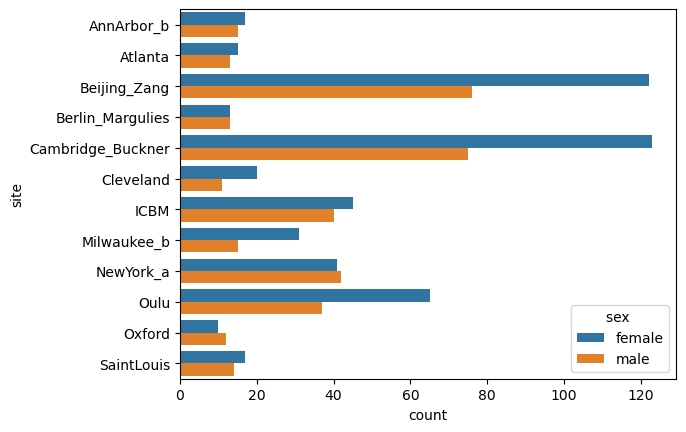

In [4]:
# Group the data by site and sex
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")

# Get the sites with only one sex present
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index

# remove the sites with less than 10 samples
data = data[~data["site"].isin(sites_with_one_sex.index)]


# find the sites that have less than 10 samples
site_counts = site_counts[site_counts["counts"] < 10]

# remove the sites with less than 10 samples
data = data[~data["site"].isin(site_counts["site"])]

sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

We find the seven largest sites, which we will use for train and transfer. Two of those are randomly selected for transfering later.

In [5]:
site_counts = data.groupby(["site"]).size().reset_index(name="counts")
site_counts = site_counts.sort_values("counts", ascending=False)
site_counts = site_counts.head(7)
display(site_counts)
site_counts

np.random.seed(45)
# randomly select 2 sites from the top 7 sites for transfering
transfer_sites = site_counts.sample(2)["site"]
display(transfer_sites)
transfer_data = data[data["site"].isin(transfer_sites)]

# The remaining sites are used for training the model
fit_sites = site_counts[~site_counts.isin(transfer_sites)]["site"]
fit_sites.dropna(inplace=True)
display(fit_sites)
fit_data = data[data["site"].isin(fit_sites)]

,site,counts
2,Beijing_Zang,198
4,Cambridge_Buckner,198
9,Oulu,102
6,ICBM,85
8,NewYork_a,83
7,Milwaukee_b,46
0,AnnArbor_b,32


7    Milwaukee_b
9           Oulu
Name: site, dtype: object

2         Beijing_Zang
4    Cambridge_Buckner
6                 ICBM
8            NewYork_a
0           AnnArbor_b
Name: site, dtype: object

Next, we load the data into `NormData` objects. All functions in the PCNtoolkit expect the data to be provided as instances of the `NormData` class. The class manages all preprocessing, basis expansions, and dimensions. 

In [6]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]

# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(
    name="fit",  # name of the dataset
    dataframe=fit_data,  # pandas dataframe
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

# Create a transfer data object from the downloaded data
transfer_data = NormData.from_dataframe(
    name="transfer",
    dataframe=transfer_data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)


# other methods to create normdata object:
# NormData.from_ndarrays
# NormData.from_xarray

display(normdata)

<xarray.NormData> Size: 55kB
Dimensions:            (datapoints: 596, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 31kB 'datapoint_0' ... 'datapoint_595'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 5kB 68.0 19.0 ... 19.65
    y                  (datapoints, response_vars) float64 10kB 2.272 ... 1.8...
    batch_effects      (datapoints, batch_effect_dims) object 10kB 0 ... 'New...
Attributes:
    name:                fit
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_b': 0, 'Bei...

The NormData object has a number of useful attributes and functions, inherited from the `xarray.Dataset` class. A convenience function `select_batch_effects` is also available for quick filtering by site or sex(in this case). 

In [7]:
# Select specific points
two_points = normdata.sel(datapoints=["datapoint_0", "datapoint_100"])
display(two_points)

# Filter by site and sex
one_site = normdata.select_batch_effects({"site": ["AnnArbor_a"], "sex": [0]})
display(one_site)

# Filter by age
over_30 = normdata.where(normdata.X > 30, drop=True)
display(over_30)

<xarray.NormData> Size: 436B
Dimensions:            (datapoints: 2, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 104B 'datapoint_0' 'datapoint_100'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 16B 68.0 20.0
    y                  (datapoints, response_vars) float64 32B 2.272 ... 1.2e+03
    batch_effects      (datapoints, batch_effect_dims) object 32B 0 ... 'Beij...
Attributes:
    name:                fit
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_b': 0, 'Bei...

<xarray.NormData> Size: 32kB
Dimensions:            (datapoints: 348, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 18kB 'datapoint_0' ... 'datapoint_590'
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 3kB 68.0 19.0 ... 26.27
    y                  (datapoints, response_vars) float64 6kB 2.272 ... 883.7
    batch_effects      (datapoints, batch_effect_dims) object 6kB 0 ... 'NewY...
Attributes:
    name:                fit_selected
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_b': 0, 'Bei...

<xarray.Dataset> Size: 9kB
Dimensions:            (datapoints: 94, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 5kB 'datapoint_0' ... 'datapoint_586'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 752B 68.0 73.0 ... 49.16
    y                  (datapoints, response_vars, covariates) float64 2kB 2....
    batch_effects      (datapoints, batch_effect_dims, covariates) object 2kB ...
Attributes:
    name:                fit
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_b': 0, 'Bei...

Splitting the data into train and test splits is also easy:

In [8]:
# Split data into training and test sets
# the splits are automatically stratified on the batch_effects
train, test = normdata.train_test_split(
    splits=[0.8, 0.2], split_names=["train", "test"]
)
display(train)
display(test)
transfer_train, transfer_test = transfer_data.train_test_split(
    splits=[0.8, 0.2], split_names=["transfer_train", "transfer_test"]
)

<xarray.NormData> Size: 44kB
Dimensions:            (datapoints: 476, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 25kB 'datapoint_575' ... 'datapoint_...
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 4kB 26.33 22.0 ... 30.14
    y                  (datapoints, response_vars) float64 8kB 2.527 ... 1.01...
    batch_effects      (datapoints, batch_effect_dims) object 8kB 1 ... 'NewY...
Attributes:
    name:                train
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_b': 0, 'Bei...

<xarray.NormData> Size: 11kB
Dimensions:            (datapoints: 120, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U13 6kB 'datapoint_244' ... 'datapoint_355'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 960B 20.0 22.0 ... 20.0
    y                  (datapoints, response_vars) float64 2kB 2.486 ... 1.82...
    batch_effects      (datapoints, batch_effect_dims) object 2kB 1 ... 'Camb...
Attributes:
    name:                test
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_b': 0, 'Bei...

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [9]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    save_dir="resources/save_dir",
    log_dir="resources/log_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    order=3,
    nknots=5,
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a SHASHb likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. 

In [10]:
# Configure mu
mu = Param(
    name="mu",
    linear=True,
    slope=Param("slope_mu", dims=("covariates",), dist_params=(0.0, 5.0)),
    intercept=Param("intercept_mu", random=True),
)
# Configure sigma
sigma = Param(
    name="sigma",
    linear=True,
    slope=Param("slope_sigma", dims=("covariates",), dist_params=(0.0, 5.0)),
    mapping="softplus",
)
# Configure epsilon
epsilon = Param(name="epsilon", linear=False, dist_name="Normal", dist_params=(1.0,))
# Configure delta
delta = Param(name="delta", linear=False, dist_name="LogNormal", dist_params=(1,))

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=15,
    tune=5,
    chains=4,
    cores=16,
    likelihood="Normal",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
)

Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [11]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [12]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the model
With all our configuration done, we can fit our model on the train data. 

In [13]:
norm_hbr.fit(train)

Only 15 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Going to fit 2 models
Fitting model for rh_MeanThickness_thickness


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma]


Output()

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pytensor/tensor/subtensor.py:2892: RuntimeWarning: invalid value encountered in at
  np.add.at(out[0], tuple(indices), y)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pytensor/tensor/subtensor.py:2892: RuntimeWarning: invalid value encountered in at
  np.add.at(out[0], tuple(indices), y)


Sampling 4 chains for 5 tune and 15 draw iterations (20 + 60 draws total) took 1 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 15 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Fitting model for WM-hypointensities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma]


Output()

Sampling 4 chains for 5 tune and 15 draw iterations (20 + 60 draws total) took 1 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


In [14]:
a = norm_hbr.regression_models["rh_MeanThickness_thickness"]
a.idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [15]:
norm_hbr.current_regression_model

## Save the model

In [16]:
# The results are saved in the save_dir specified in the norm_conf
norm_hbr.save()

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

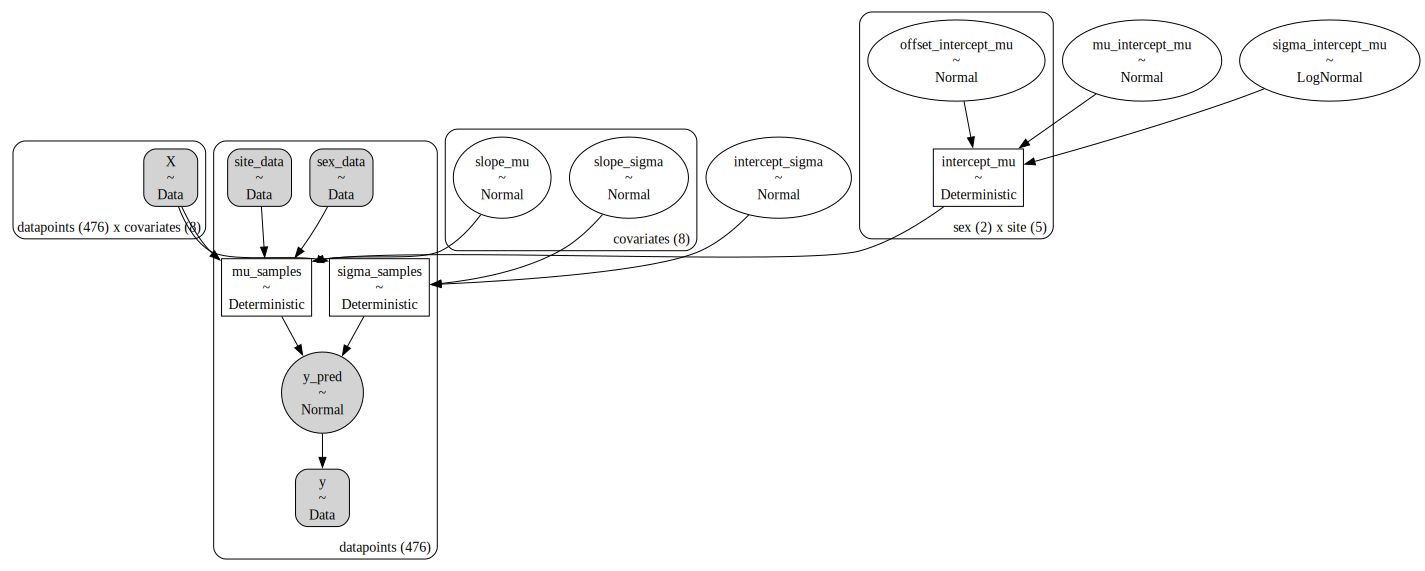

In [17]:
model = norm_hbr.regression_models.get("rh_MeanThickness_thickness")
model.pymc_model.to_graphviz()

## Load the norm_hbr model from disk

In [18]:
norm_hbr = load_normative_model("resources/save_dir")

Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.


## Predict on the test set


In [19]:
norm_hbr.predict(test)

Sampling: [y_pred]


Output()

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Sampling: [y_pred]


Output()

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:203: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


## Evaluation
Calling `predict` will extend the `NormData` object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [20]:
display(test.measures.to_dataframe())

measures
response_vars              statistics             
rh_MeanThickness_thickness Rho            0.151188
                           RMSE           0.096639
                           SMSE           1.666267
                           ExpV          -0.646532
                           NLL                 NaN
                           ShapiroW       0.971849
WM-hypointensities         Rho            0.227961
                           RMSE        1035.158361
                           SMSE           1.060090
                           ExpV          -0.002042
                           NLL                 NaN
                           ShapiroW       0.923880

Datasets with a zscores DataArray will have the `.plot_qq()` function available:

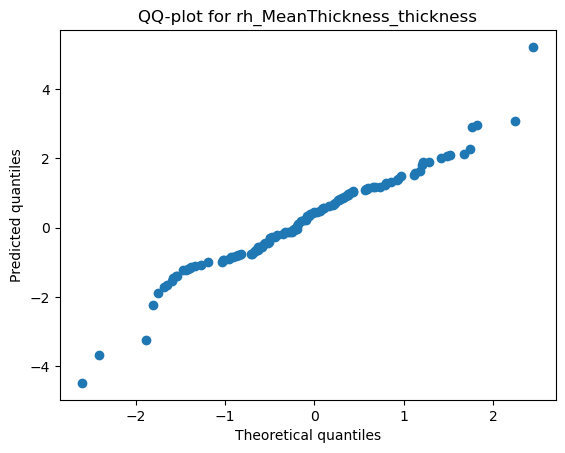

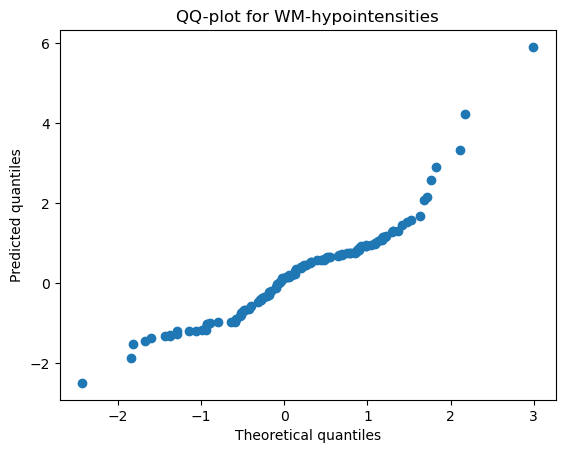

In [21]:
# display(test.zscores) # the zscores
test.plot_qq()  # Convenience function that plots the qq plot of the zscores

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`test` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.1587, 0.25, 0.5, 0.75, 0.8413, 0.95]. 

The CDF values of 0.1587 and 0.8413 respectively correspond to a standard deviation of -1 and 1.


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


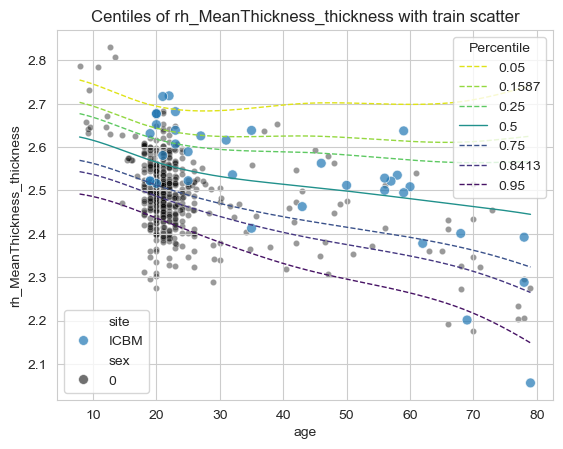

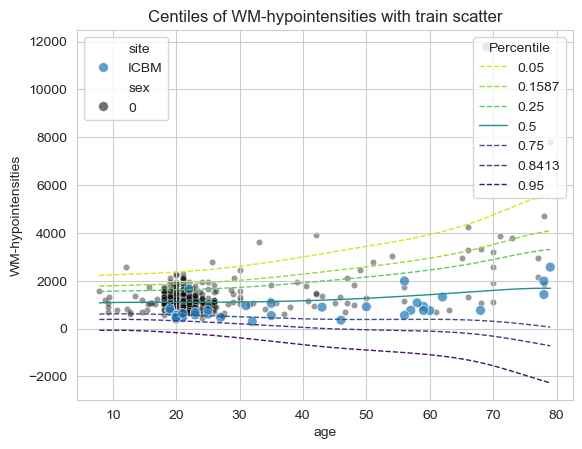

In [24]:
# test.centiles # the centiles
norm_hbr.plot_centiles(
    train, covariate="age", batch_effects={"sex": [0], "site": ["ICBM"]}, show_data=True
)

## Transfer

We transfer the model to the transfer_train dataset that we created before. The posterior distribution is factorized and a new RegConf is created using the factorized posterior as a prior. To give some extra control, we let the `freedom` parameter control the variance of the derived factorized posterior. With a `freedom` of 1, the factorized representation is used as is. With freedom of `2`, all derived scale parameters are multiplied with a factor of 2, resulting in a wider prior. 

In [ ]:
transfered_model = norm_hbr.transfer(transfer_train, freedom=2)

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness
Approximating marginal distribution for slope_mu with Normal and freedom 2
Approximating marginal distribution for mu_intercept_mu with Normal and freedom 2
Approximating marginal distribution for sigma_intercept_mu with LogNormal and freedom 2
Approximating marginal distribution for slope_sigma with Normal and freedom 2
Approximating marginal distribution for intercept_sigma with Normal and freedom 2
Approximating marginal distribution for epsilon with Normal and freedom 2
Approximating marginal distribution for delta with LogNormal and freedom 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 723 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Transferring model for WM-hypointensities
Approximating marginal distribution for slope_mu with Normal and freedom 2
Approximating marginal distribution for mu_intercept_mu with Normal and freedom 2
Approximating marginal distribution for sigma_intercept_mu with LogNormal and freedom 2
Approximating marginal distribution for slope_sigma with Normal and freedom 2
Approximating marginal distribution for intercept_sigma with Normal and freedom 2
Approximating marginal distribution for epsilon with Normal and freedom 2
Approximating marginal distribution for delta with LogNormal and freedom 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 1082 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Configuration of normative model is valid.


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path

In [ ]:
transfered_model.save()

Saving normative model to resources/save_dir_transfer/normative_model_dict.json


In [ ]:
transfered_model = load_normative_model("resources/save_dir_transfer")
transfered_model.predict(transfer_test)

Loading normative model from resources/save_dir_transfer
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:467: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


In [ ]:
display(transfer_test.measures.to_dataframe())

measures
response_vars              statistics            
rh_MeanThickness_thickness Rho           0.614887
                           RMSE          0.078575
                           SMSE          0.816828
                           ExpV          0.337673
                           NLL                NaN
                           ShapiroW      0.814096
WM-hypointensities         Rho           0.525793
                           RMSE        577.011443
                           SMSE          1.597904
                           ExpV          0.292550
                           NLL                NaN
                           ShapiroW      0.896296

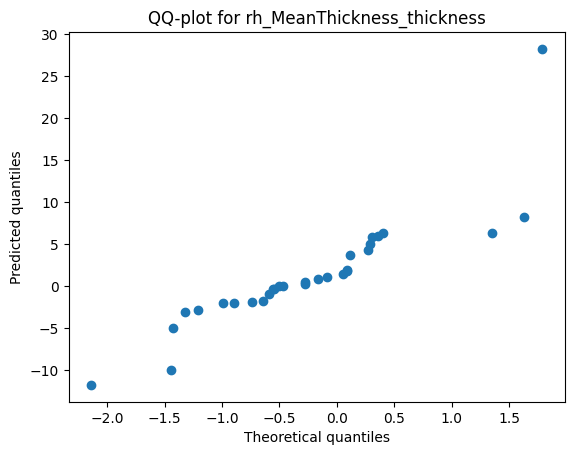

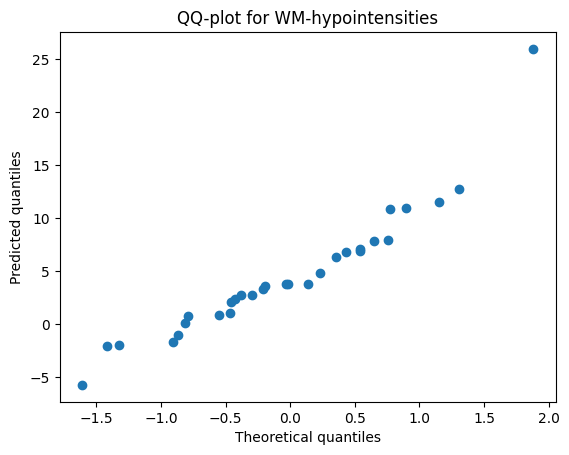

In [ ]:
transfer_test.plot_qq()

Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


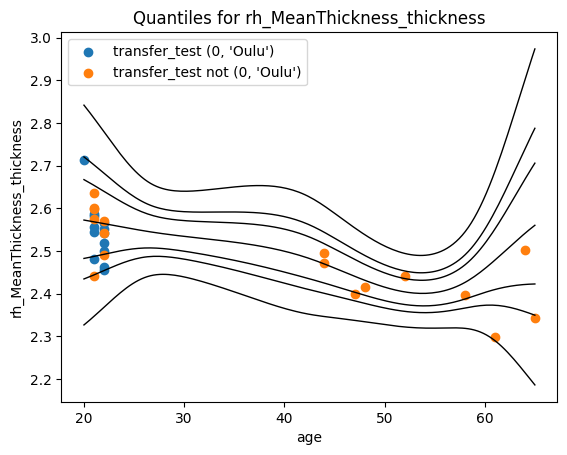

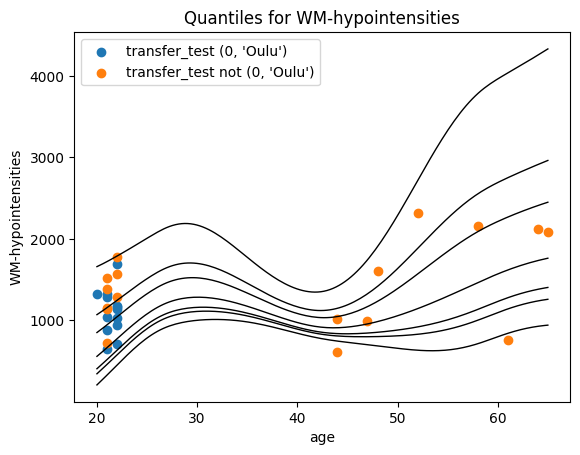

In [ ]:
transfered_model.plot_centiles(
    transfer_test, covariate="age", batch_effects=(0, "Oulu"), show_data=True
)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!